In [1]:
import os 
import sys
sys.path.append('../dependencies/')   # _______ see ? 
import shutil
import flopy
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import shapefile as sf
from shapely.geometry import Polygon, LineString, MultiLineString, Point

In [2]:
org_workspace = os.path.join('..','models','sgn_model_1layer')  
workspace = os.path.join('..','models','sgn_model_1layer_transport')
if os.path.exists(workspace):
    shutil.rmtree(workspace)
shutil.copytree(org_workspace, workspace)    
datadir = os.path.join('..','data','sgn')
bindir = os.path.join('..','bin')

In [3]:
sim = flopy.mf6.MFSimulation.load(sim_ws=workspace)
# print(sim.model_names)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package riv...
    loading package drn...
    loading package wel...
    loading package ghb...
    loading package obs...
    loading package oc...
  loading solution package sgn...


In [4]:
gwf = sim.get_model("sgn")

In [5]:
sim.tdis.perioddata.set_data([50*365*24*60*60, 4, 1.1])       #  50 years    # sim.tdis.perioddata

In [6]:
sto = flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, steady_state=[True])          # sim.write_simulation()

# **Transport Package**

In [7]:
gwtname = "gwt-sgn"
gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname, model_nam_file=f'{gwtname}.nam')
gwt.name_file.save_flows = True
nouter, ninner,             hclose, rclose, relax  = 100, 500,       1e-6, 1e-6, 1.0

imsgwt = flopy.mf6.ModflowIms(sim, print_option="SUMMARY", outer_dvclose=hclose, outer_maximum=nouter, under_relaxation="NONE",
                                    inner_maximum=ninner, inner_dvclose=hclose, rcloserecord=rclose, linear_acceleration="BICGSTAB",
                                    scaling_method="NONE", reordering_method="NONE", relaxation_factor=relax, filename="{}.ims".format(gwtname))
sim.register_ims_package(imsgwt, [gwt.name])

In [8]:
flopy.mf6.ModflowGwtdisv(gwt, nlay=gwf.dis.nlay.get_data(),ncpl=gwf.dis.ncpl.get_data(),length_units=gwf.dis.length_units.get_data(),
                        top=gwf.dis.top.get_data(),botm=gwf.dis.botm.get_data(),nvert=gwf.dis.nvert.get_data(), vertices=gwf.dis.vertices.get_data(), 
                        cell2d=gwf.dis.cell2d.get_data(),idomain=gwf.dis.idomain.get_data(),filename="{}.dis".format(gwtname))
sconc = 0.0
flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f'{gwtname}.ic')                   # initial concentrations ____________ ! __________

scheme = "UPSTREAM"
adv = flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")        # advection ______________________________________

al, ath1, atv, dmcoef = 30, 3, 3, 1.02E-9  # (m^2/s)                                # Longitudinal dispersivity # Dispersion  (3,3)
flopy.mf6.ModflowGwtdsp(gwt, alh=al, ath1=ath1, atv=atv, diffc=dmcoef, pname="DSP-1", filename="{}.dsp".format(gwtname),)   # dispersion 

prsity = 0.2
flopy.mf6.ModflowGwtmst( gwt, porosity=prsity, pname="MST-1", filename="{}.mst".format(gwtname),)

sourcerecarray = [()] #("CHD-1", "AUX", "CONCENTRATION")]
flopy.mf6.ModflowGwtssm( gwt, sources=sourcerecarray, print_flows=True, filename="{}.ssm".format(gwtname))  # source-sink mixing package

flopy.mf6.ModflowGwtoc(gwt, budget_filerecord="{}.cbc".format(gwtname), concentration_filerecord="{}.ucn".format(gwtname),
                        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")], saverecord=[("CONCENTRATION", "LAST"),("BUDGET", "LAST")],
                        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")], filename="{}.oc".format(gwtname))    #____OC

flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',exgmnamea=gwf.name,  exgmnameb=gwt.name, filename="{}.gwfgwt".format('sgn')) # flow-transport exchange 

package_name = sgn.gwfgwt
filename = sgn.gwfgwt
package_type = gwfgwt
model_or_simulation_package = simulation
simulation_name = modflowsim


## E:\15_REPOS\d03_Beta-Me\02_Symple\data\sgn\shp
<font color='red'> the shapefile records contain the concentration in the second to last attribute "column"; the fourth to last identfies the source location </font>


In [9]:
ix = GridIntersect(gwf.modelgrid)
conc_shpfile = os.path.join(datadir, 'shp', 'real_unknown_sources.shp')
conc_shapes = sf.Reader(conc_shpfile).shapes()
conc_spd=[]
for i in range(len(conc_shapes)):
    shp = conc_shapes[i]
    record = sf.Reader(conc_shpfile).record(i)
    conc_i = record[-2]                           # -2  ...    
    conc_site = record[-4]                        # -4  ...   
        
    cellids = ix.intersect(shp).cellids           # get the intersect
    for icpl in cellids:
        conc_spd.append(((0, icpl), conc_i, f'conc-{conc_site}'))
        
cnc = flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=conc_spd, boundnames=True)

## **OBS  Transport** 

In [10]:
obs_shpfile = os.path.join(datadir, 'shp', 'Target_L1_sept2019_head_PCE.shp')
obs_shapes = sf.Reader(obs_shpfile).shapes()

obs_list=[]
for i in range(len(obs_shapes)):
    shp = obs_shapes[i]
    cellids = ix.intersect(shp).cellids

    record = sf.Reader(obs_shpfile).record(i)
    piezid = record[0]
    
    for icpl in cellids:
        obs_list.append((f'{piezid}', 'CONCENTRATION', (0, icpl))) 
        
        
obs_recarray = {'conc_obs.csv':obs_list}

obs_package = flopy.mf6.ModflowUtlobs(gwt, digits=10, print_input=True, continuous=obs_recarray)

In [11]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package sgn...
  writing solution package ims_0...
  writing package sgn.gwfgwt...
  writing model sgn...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rch_obs...
    writing package rch...
    writing package riv_obs...
    writing package riv_0...
    writing package drn_obs...
    writing package drn_0...
    writing package wel_obs...
    writing package wel_0...
    writing package ghb_obs...
    writing package ghb_0...
    writing package obs_5...
    writing package oc...
    writing package sto...
  writing model gwt-sgn...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package adv...
    writing package dsp-1...
    writing package mst-1...
    writing package ssm...
    writing package oc...
    writing package cnc_0...
INFORMATION

In [12]:
sim.run_simulation()

FloPy is using the following executable to run the model: C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\envs\gmdsitut\Scripts\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition

(True, [])

In [13]:
fname = os.path.join(workspace, gwf.name + '.hds')
hdobj = flopy.utils.HeadFile(fname, model=gwf)
head = hdobj.get_alldata()

hmin = head.min()
hmax = head.max()

print(f'Max head in model run: {hmax}')
print(f'Min head in model run: {hmin}')

head.shape

Max head in model run: 103.02480417428924
Min head in model run: 97.08268291697539


(1, 1, 1, 22488)

<Axes: title={'center': 'data Layer 1'}>

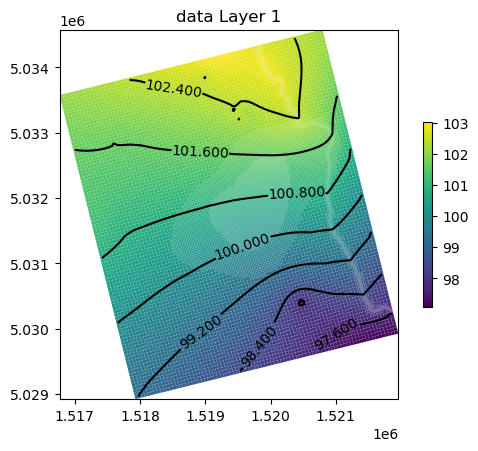

In [14]:
# get the times at which values are recorede in the heads file
hdtimes = hdobj.get_times()
# generic plot of head data
hdobj.plot(mflay=0, totim=hdtimes[0] ,colorbar=True, contour=True, clabel=True)

# **not missing ______  gwt-sgn.ucn**

In [15]:
 #Get the MF6 concentration output
fname_mf6 = os.path.join(workspace, f"{gwt.name}.ucn")

ucnobj_mf6 = flopy.utils.HeadFile(fname_mf6, precision="double", text="CONCENTRATION")

times_mf6 = ucnobj_mf6.get_times()
conc_mf6 = ucnobj_mf6.get_alldata()

In [16]:
# get the head output
fname = os.path.join(workspace, list(sim.model_names)[0] + '.hds')
hdobj = flopy.utils.HeadFile(fname, model=gwf)
head = hdobj.get_alldata()

hmin = head.min()
hmax = head.max()

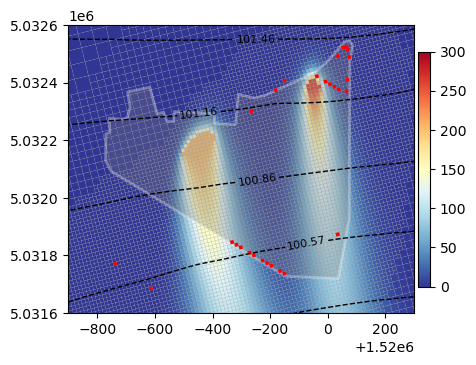

In [18]:
fig = plt.figure(figsize=(5, 5), tight_layout=True)
ax = fig.add_subplot(111, aspect='equal')
ext_offset = 500
extent= (1519100, 1520300, 5031600, 5032600) # xmin, xmax  # ymin, ymax
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0, extent=extent)
cint = (hmax-hmin)/20
levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
cs = mm.contour_array(head[0, 0, 0, :], colors='black', levels=levels, linestyles="--", linewidths=1)
plt.clabel(cs, fmt='%.2f', fontsize=8, inline=True)

a = ucnobj_mf6.get_data(mflay=0, idx=0)

ca = mm.plot_array(edgecolor='grey', a=a, cmap='RdYlBu_r',   alpha=1, linewidth=0.1, vmin=0, vmax=300)
cb = plt.colorbar(ca, shrink=0.5, pad=0.01, )

flopy.plot.plot_shapefile(sf.Reader(os.path.join(datadir, 'shp','Site_area.shp')), linewidth=2, facecolor='grey', edgecolor='w', alpha=0.3);
wells = mm.plot_bc("WEL")